# Аналитика в Яндекс.Афише

## Описание проекта 

<strong>Данные</strong>

Данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года.

1. Лог сервера с данными о посещениях сайта Яндекс.Афиши:
 - Uid — уникальный идентификатор пользователя
 - Device — категория устройства пользователя
 - Start Ts — дата и время начала сессии
 - End Ts — дата и время окончания сессии
 - Source Id — идентификатор рекламного источника, из которого пришел пользователь


2. Выгрузка всех заказов за этот период:
 - Uid — уникальный id пользователя, который сделал заказ
 - Buy Ts — дата и время заказа
 - Revenue — выручка Яндекс.Афиши с этого заказа


3. Статистика рекламных расходов:
 - source_id — идентификатор рекламного источника
 - dt — дата
 - costs — затраты на этот рекламный источник в этот день

<strong>Задача</strong>

Определить:\
 - Как люди пользуются продуктом?
 - Когда они начинают покупать?
 - Сколько денег приносит каждый клиент?
 - Когда клиент окупается?

### Шаг 1. Загрузка данных и подготовка к анализу 

In [2]:
import pandas as pd

In [3]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [6]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Даты в типе object, нужно изменить на datetime, чтобы можно было работать с датами. Остальное в порядке, пропусков нет.

In [7]:
visits['End Ts'] = pd.to_datetime(visits['End Ts'], format='%Y-%m-%d %H:%M:%S')
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'], format='%Y-%m-%d %H:%M:%S')
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'], format='%Y-%m-%d %H:%M:%S')
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')

In [8]:
visits.duplicated().sum()

0

In [9]:
orders.duplicated().sum()

0

In [10]:
costs.duplicated().sum()

0

In [11]:
visits.isnull().sum()

Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64

In [12]:
orders.isnull().sum()

Buy Ts     0
Revenue    0
Uid        0
dtype: int64

In [13]:
costs.isnull().sum()

source_id    0
dt           0
costs        0
dtype: int64

### Шаг 2. Построение отчётов и расчет метрик

#### Продукт

<strong>Сколько людей пользуются в день, неделю, месяц?</strong>

Создадим столбец с датами, без времени.

In [14]:
visits['date'] = visits['Start Ts'].dt.date

In [15]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid,date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27


Сделаем группировку по дням и посчитаем кол-во уникальных пользователей в день

In [16]:
dau_total = visits.groupby('date').agg({'Uid': 'nunique'}).reset_index()
dau_total.columns = ['date', 'Uid']
dau_total.head()

,date,Uid
0,2017-06-01,605
1,2017-06-02,608
2,2017-06-03,445
3,2017-06-04,476
4,2017-06-05,820


In [17]:
dau_total.mean()

Uid    907.991758
dtype: float64

<code style="background:lavender;color:black">В среднем в день заходят 907 уникальных пользователей

In [18]:
import matplotlib.pyplot as plt

Создадим столбцы с годом и неделей, чтобы в дальнейшем сделать группировку по неделям

In [19]:
visits['week'] = visits['Start Ts'].dt.week
visits['year'] = visits['Start Ts'].dt.year

In [20]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid,date,week,year
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,2017
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2018
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,2017
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,2018
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,2017


In [21]:
wau_total = visits.groupby(['year', 'week']).agg({'Uid': 'nunique'}).reset_index()
wau_total.head()

,year,week,Uid
0,2017,22,2021
1,2017,23,4129
2,2017,24,2812
3,2017,25,2878
4,2017,26,3064


In [22]:
wau_total['Uid'].mean()

5716.245283018868

<code style="background:lavender;color:black">В среднем в неделю на сайт заходит 5716 уникальных пользователей

В табличке visits создадим столбец month для группировки по месяцам

In [23]:
visits['month'] = visits['Start Ts'].astype('datetime64[M]')

In [24]:
visits['month'] = visits['month'].dt.date

In [25]:
mau_total = visits.groupby('month').agg({'Uid': 'nunique'}).reset_index()

In [26]:
mau_total.head()

,month,Uid
0,2017-06-01,13259
1,2017-07-01,14183
2,2017-08-01,11631
3,2017-09-01,18975
4,2017-10-01,29692


In [27]:
mau_total['Uid'].mean()

23228.416666666668

<code style="background:lavender;color:black"> В среднем на сайт заходит 23228 уникальных пользователей в месяц

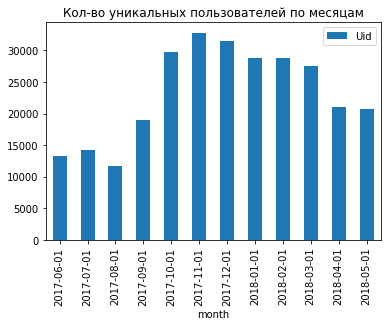

In [28]:
mau_total.plot(kind='bar', x='month', y='Uid', title='Кол-во уникальных пользователей по месяцам')

<code style="background:lavender;color:black">Из этого графика можем увидеть как менялось кол-во уникальных пользователей в месяц с течением времени. Больше всего пользователей было в ноябре 2017 года, сайт посетило более 30 тыс.человек

In [29]:
mau_total_device = visits.groupby(['month', 'Device']).agg({'Uid': 'nunique'}).reset_index()

In [30]:
mau_total_device.head()

,month,Device,Uid
0,2017-06-01,desktop,9761
1,2017-06-01,touch,3655
2,2017-07-01,desktop,10145
3,2017-07-01,touch,4223
4,2017-08-01,desktop,8611


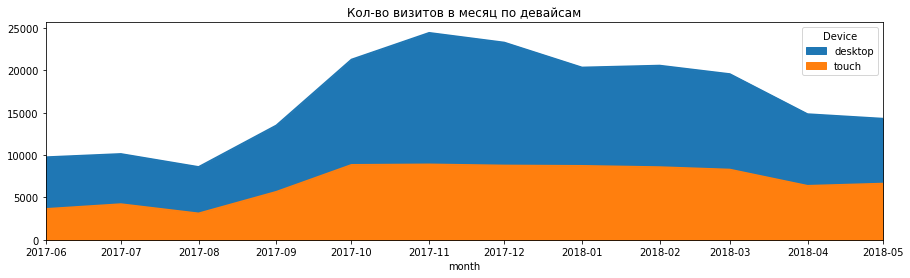

In [31]:
fig, ax = plt.subplots(figsize=(15, 4))
devices = ['desktop', 'touch']
for d in devices:
    (
        mau_total_device
        .query('Device == @d')
        .pivot_table(index='month', columns='Device', values='Uid', aggfunc='first')
        .plot(ax=ax, kind='area', stacked=True, title='Кол-во визитов в месяц по девайсам')
    )

<code style="background:lavender;color:black">За все время с desktop версии заходит больше людей, чем с touch

In [32]:
visits = visits.rename(columns={'Source Id': 'source_id'})

In [33]:
mau_total_source = visits.groupby(['month', 'source_id']).agg({'Uid': 'nunique'}).reset_index()

In [34]:
mau_total_source.head()

,month,source_id,Uid
0,2017-06-01,1,972
1,2017-06-01,2,1532
2,2017-06-01,3,4226
3,2017-06-01,4,3636
4,2017-06-01,5,2903


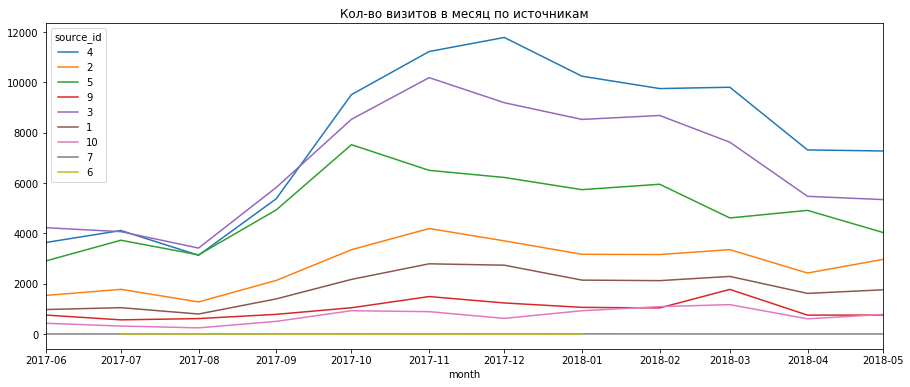

In [35]:
fig, ax = plt.subplots(figsize=(15, 6))
sources = visits['source_id'].unique()
for s in sources:
    (
        mau_total_source
        .query('source_id == @s')
        .pivot_table(index='month', columns='source_id', values='Uid', aggfunc='first')
        .plot(ax=ax, kind='line', stacked=True, title='Кол-во визитов в месяц по источникам')
    )

<code style="background:lavender;color:black">Больше всего визитов приходит с источников 4, 3 и 5, меньше всего 10 и 9, из источников 6 и 7 не заходили(скорее всего из этих источников не было привлечения)

<strong>Сколько сессий в день?</strong>

In [36]:
sessions_daily = visits.groupby('date').agg({'Uid': 'count'}).reset_index()
sessions_daily.head()

,date,Uid
0,2017-06-01,664
1,2017-06-02,658
2,2017-06-03,477
3,2017-06-04,510
4,2017-06-05,893


In [37]:
sessions_daily['Uid'].mean()

987.3626373626373

<code style="background:lavender;color:black">В день в среднем 987 сессий

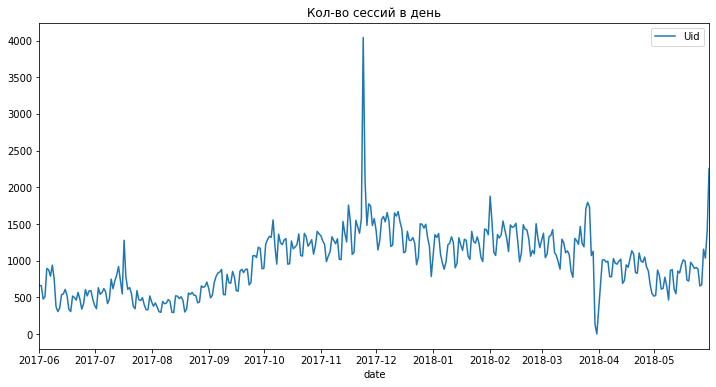

In [38]:
sessions_daily.plot(kind='line', x='date', y='Uid', title='Кол-во сессий в день', figsize=(12, 6))

<code style="background:lavender;color:black">Наибольшее кол-во сессий было в ноябре 2017

Теперь посчитаем в разрезе устройств

In [39]:
sessions_daily_device = visits.groupby(['date', 'Device']).agg({'Uid': 'count'}).reset_index()
sessions_daily_device.head()

,date,Device,Uid
0,2017-06-01,desktop,501
1,2017-06-01,touch,163
2,2017-06-02,desktop,498
3,2017-06-02,touch,160
4,2017-06-03,desktop,329


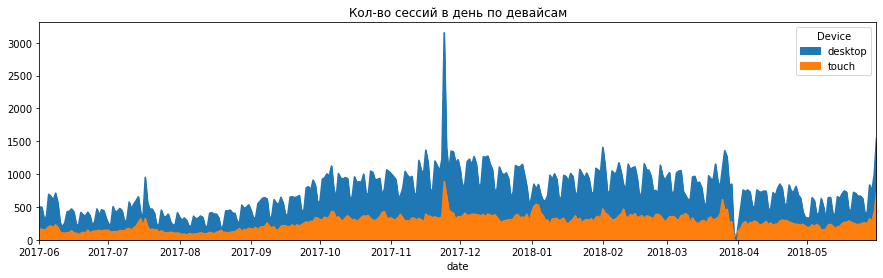

In [40]:
fig, ax = plt.subplots(figsize=(15, 4))
devices=['desktop', 'touch']
for d in devices:
    (
        sessions_daily_device
        .query('Device == @d')
        .pivot_table(index='date', columns='Device', values='Uid', aggfunc='first')
        .plot(ax=ax, kind='area', stacked=True, title='Кол-во сессий в день по девайсам')
    )

<code style="background:lavender;color:black"> с десктоп больше кол-во сессий

Посчитаем в разрезе источников

In [41]:
sessions_daily_source = visits.groupby(['date', 'source_id']).agg({'Uid': 'count'}).reset_index()
sessions_daily_source.head()

,date,source_id,Uid
0,2017-06-01,1,70
1,2017-06-01,2,85
2,2017-06-01,3,185
3,2017-06-01,4,141
4,2017-06-01,5,122


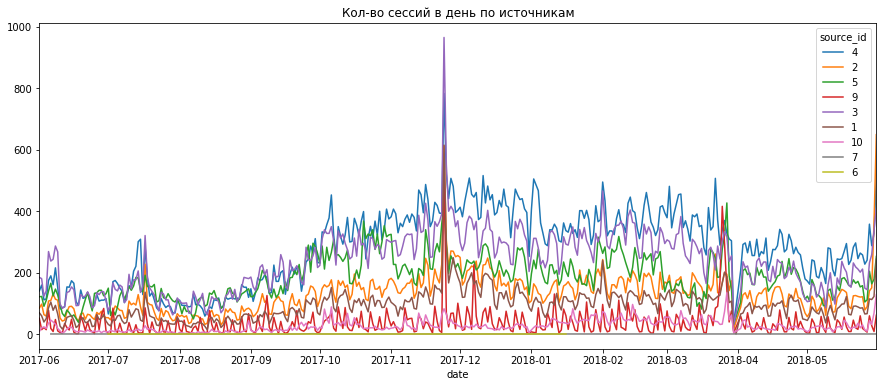

In [42]:
fig, ax = plt.subplots(figsize=(15, 6))
sources = visits['source_id'].unique()
for s in sources:
    (
        sessions_daily_source
        .query('source_id == @s')
        .pivot_table(index='date', columns='source_id', values='Uid', aggfunc='first')
        .plot(ax=ax, kind='line', stacked=True, title='Кол-во сессий в день по источникам')
    )

<code style="background:lavender;color:black">По кол-ву сессий заходят больше всего из источников 4 и 3

<strong>Сколько длится одна сессия?</strong>

In [43]:
visits['session_duration_sec'] = (visits['End Ts'] - visits['Start Ts']).dt.seconds

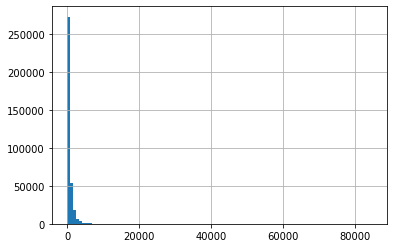

In [45]:
visits['session_duration_sec'].hist(bins=100)

Поскольку распределение не близко к нормальному, то вместо среднего будем вычислять моду

In [46]:
visits['session_duration_sec'].mode()

0    60
dtype: int64

<code style="background:lavender;color:black">В среднем сессия длится 60 секунд

In [47]:
session_duration_monthly = visits.groupby('month').agg({'session_duration_sec': 'mean'}).reset_index()
session_duration_monthly.head()

,month,session_duration_sec
0,2017-06-01,600.024114
1,2017-07-01,604.636246
2,2017-08-01,589.093905
3,2017-09-01,597.190446
4,2017-10-01,614.486083


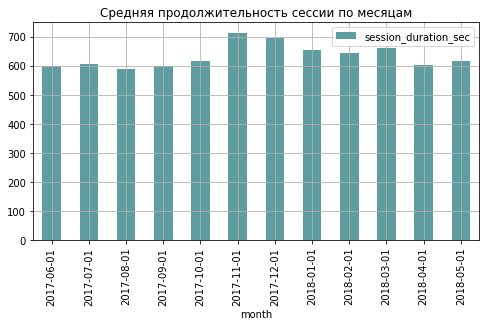

In [48]:
session_duration_monthly.plot(kind='bar', x='month', y='session_duration_sec', title='Средняя продолжительность сессии по месяцам', grid=True, figsize=(8, 4), color = 'CadetBlue', legend=True)

<code style="background:lavender;color:black">Средняя продолжительность сессии с течением времени меняется не сильно и остается примерно на том же уровне (5 минут)

In [49]:
session_duration_monthly_device = visits.groupby(['month', 'Device']).agg({'session_duration_sec': 'mean'}).reset_index()

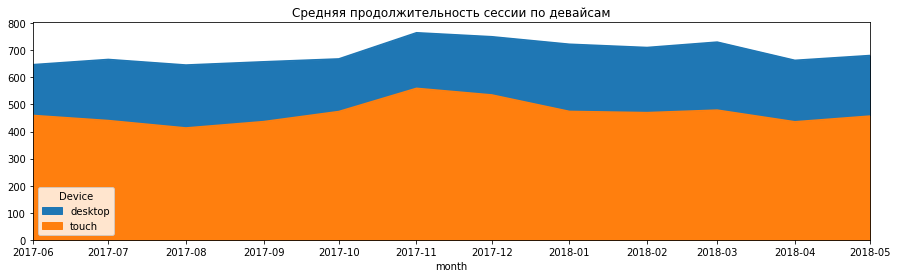

In [50]:
fig, ax = plt.subplots(figsize=(15, 4))
devices=['desktop', 'touch']
for d in devices:
    (
        session_duration_monthly_device
        .query('Device == @d')
        .pivot_table(index='month', columns='Device', values='session_duration_sec', aggfunc='first')
        .plot(ax=ax, kind='area', stacked=True, title='Средняя продолжительность сессии по девайсам')
    )

<code style="background:lavender;color:black">C desktop версии люди сидят на сайте дольше, около 8-11 минут, с touch меньше 6 минут

In [51]:
session_duration_monthly_source = visits.groupby(['month', 'source_id']).agg({'session_duration_sec': 'mean'}).reset_index()
session_duration_monthly_source.head()

,month,source_id,session_duration_sec
0,2017-06-01,1,978.101036
1,2017-06-01,2,851.121406
2,2017-06-01,3,511.944307
3,2017-06-01,4,519.255433
4,2017-06-01,5,492.346573


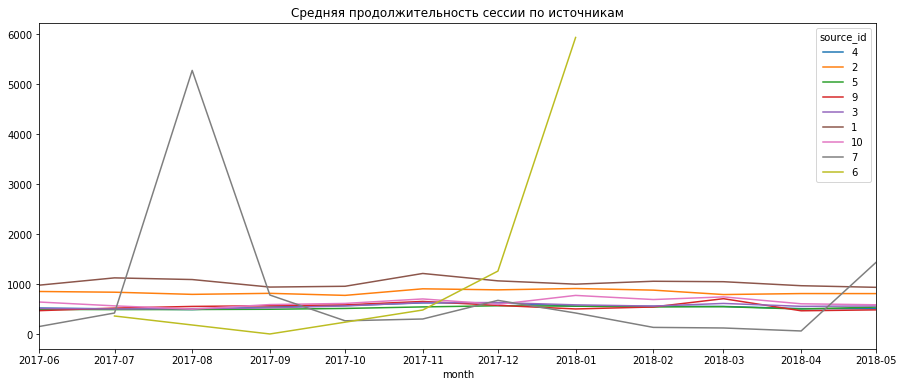

In [52]:
fig, ax = plt.subplots(figsize=(15, 6))
sources = visits['source_id'].unique()
for s in sources:
    (
        session_duration_monthly_source
        .query('source_id == @s')
        .pivot_table(index='month', columns='source_id', values='session_duration_sec', aggfunc='first')
        .plot(ax=ax, kind='line', stacked=True, title='Средняя продолжительность сессии по источникам')
    )

<code style="background:lavender;color:black">Продолжительность сессии выше у источников 1 и 2, однако у источников 7 и 6 в определенные месяцы происходил скачок роста продолжительности

<strong>Как часто люди возвращаются?</strong>

Найдем дату первой активности для каждого пользователя

In [53]:
first_activity_date = visits.groupby('Uid')['date'].min()

In [54]:
first_activity_date.name = 'first_activity_date'

Объединим датафреймы visits и полученный first_activity_date, чтобы в visits появился столбец с датой первой активности каждого пользователя

In [55]:
visits = visits.join(first_activity_date, on='Uid')

В таблице visits создадим столбец с месяцами первой активности

In [56]:
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')

И столбец с месяцами всех активностей

In [57]:
visits['date_month'] = visits['date'].astype('datetime64[M]')

In [58]:
import numpy as np

Когорты будем формировать по месяцам, для определения lifetime когорты, вычтем из месяца любой активности месяц первой активности и поделим на np.timedelta64(1, 'M')

In [59]:
visits['cohort_lifetime'] = visits['date_month'] - visits['first_activity_month']

In [60]:
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1, 'M')

In [61]:
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

Посчитаем в каждой когорте кол-во уникальных пользователей на определенный "месяц жизни"

In [62]:
cohorts = visits.groupby(['first_activity_month', 'cohort_lifetime']).agg({'Uid': 'nunique'}).reset_index()

Посчитаем кол-во пользователей на нулевой месяц жизни, то есть узнаем исходное число пользователей в когорте

In [63]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month', 'Uid']]

In [64]:
initial_users_count = initial_users_count.rename(columns={'Uid': 'cohort_users'})

In [65]:
initial_users_count.head()

,first_activity_month,cohort_users
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977


Объединим таблицы cohorts и initial_users_count, чтобы разделить столбец с кол-вом уникальных пользователей в определенный месяц жизни на столбец с исходным числом пользователей в когорте, тем самым посчитаем retention-показатель удержания пользователей

In [66]:
cohorts = cohorts.merge(initial_users_count, on='first_activity_month')

In [67]:
cohorts['first_activity_month'] = cohorts['first_activity_month'].dt.date

In [68]:
cohorts['retention'] = cohorts['Uid']/cohorts['cohort_users']

In [69]:
cohorts.head()

,first_activity_month,cohort_lifetime,Uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557


In [70]:
retention_pivot = (cohorts
                   .pivot_table(index='first_activity_month',
                                columns='cohort_lifetime',
                                values='retention',
                                aggfunc='sum'))

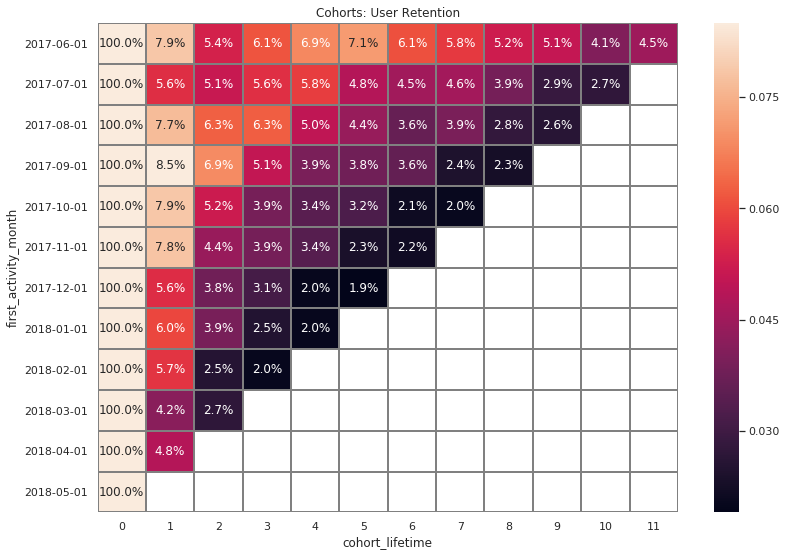

In [71]:
import seaborn as sns
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin=0.019, vmax=0.085)

<code style="background:lavender;color:black">У нас получилась сводная таблица с коэффициентами удержания пользователей. По ней можно сделать вывод о том, что люди возвращаются не очень часто.

Теперь посчитаем retention в разрезе по девайсам

In [72]:
cohorts_2 = visits.groupby(['Device', 'first_activity_month', 'cohort_lifetime']).agg({'Uid': 'nunique'}).reset_index()

In [73]:
cohorts_2.head()

,Device,first_activity_month,cohort_lifetime,Uid
0,desktop,2017-06-01,0,9761
1,desktop,2017-06-01,1,833
2,desktop,2017-06-01,2,593
3,desktop,2017-06-01,3,671
4,desktop,2017-06-01,4,741


In [74]:
initial_users_count_2 = cohorts_2[cohorts_2['cohort_lifetime'] == 0][['Device', 'first_activity_month', 'Uid']]

In [75]:
initial_users_count_2 = initial_users_count_2.rename(columns={'Uid': 'initial_users'})

In [76]:
initial_users_count_2.head()

,Device,first_activity_month,initial_users
0,desktop,2017-06-01,9761
12,desktop,2017-07-01,9312
23,desktop,2017-08-01,7450
33,desktop,2017-09-01,11715
42,desktop,2017-10-01,18451


In [77]:
cohorts_2 = cohorts_2.merge(initial_users_count_2, on = ['first_activity_month', 'Device'])

In [78]:
cohorts_2.head()

,Device,first_activity_month,cohort_lifetime,Uid,initial_users
0,desktop,2017-06-01,0,9761,9761
1,desktop,2017-06-01,1,833,9761
2,desktop,2017-06-01,2,593,9761
3,desktop,2017-06-01,3,671,9761
4,desktop,2017-06-01,4,741,9761


In [79]:
cohorts_2['retention'] = cohorts_2['Uid'] / cohorts_2['initial_users']

In [80]:
cohorts_2['first_activity_month'] = cohorts_2['first_activity_month'].dt.date

In [81]:
retention_pivot_2 = (cohorts_2.pivot_table(index=['first_activity_month','Device'],
                                          columns='cohort_lifetime',
                                          values='retention',
                                          aggfunc='sum'))

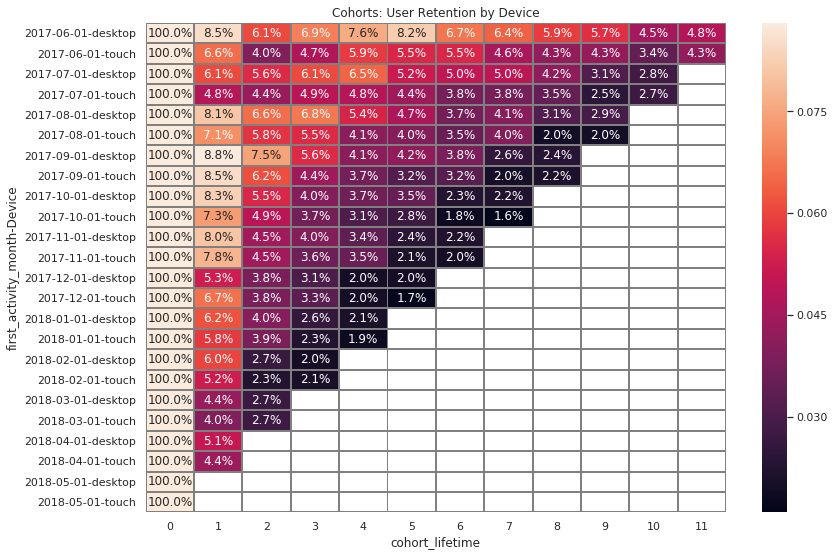

In [82]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention by Device')
sns.heatmap(retention_pivot_2, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin=0.016, vmax=0.088)

<code style="background:lavender;color:black"> Коэффициент удержания у desktop версии чуть выше, чем у touch

Теперь посмотрим retention по источникам

In [83]:
cohorts_3 = visits.groupby(['source_id', 'cohort_lifetime']).agg({'Uid': 'nunique'}).reset_index()

In [84]:
cohorts_3.head()

,source_id,cohort_lifetime,Uid
0,1,0,15227
1,1,1,1994
2,1,2,1022
3,1,3,815
4,1,4,703


In [85]:
initial_users_count_3 = cohorts_3[cohorts_3['cohort_lifetime'] == 0][['source_id', 'Uid']]

In [86]:
initial_users_count_3 = initial_users_count_3.rename(columns={'Uid': 'initial_users'})

In [87]:
initial_users_count_3.head()

,source_id,initial_users
0,1,15227
12,2,21362
24,3,68582
36,4,75922
48,5,52439


In [88]:
cohorts_3 = cohorts_3.merge(initial_users_count_3, on='source_id')

In [89]:
cohorts_3.head()

,source_id,cohort_lifetime,Uid,initial_users
0,1,0,15227,15227
1,1,1,1994,15227
2,1,2,1022,15227
3,1,3,815,15227
4,1,4,703,15227


In [90]:
cohorts_3['retention'] = cohorts_3['Uid'] / cohorts_3['initial_users']

In [91]:
retention_pivot_3 = (cohorts_3.pivot_table(index='source_id',
                                          columns='cohort_lifetime',
                                          values='retention',
                                          aggfunc='sum'))

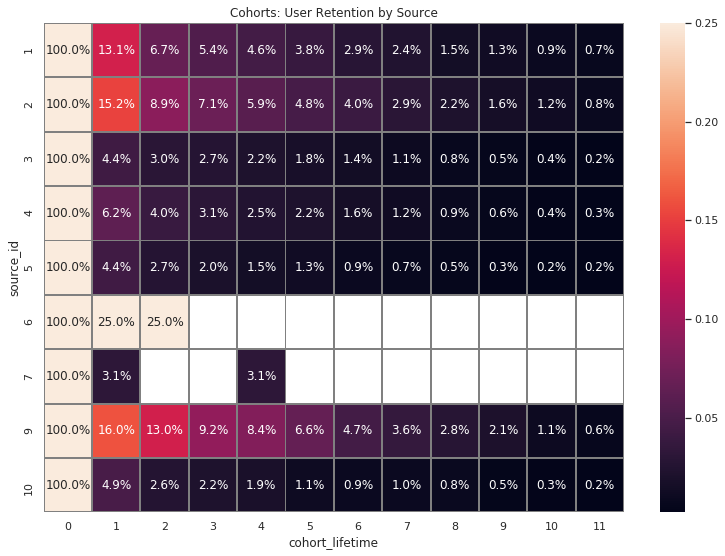

In [92]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention by Source')
sns.heatmap(retention_pivot_3, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmax=0.25, vmin=0.002)

<code style="background:lavender;color:black"> Выше всего коэффициент удержания в первые месяцы жизни у источников 6, 9, 2, 1.

#### Продажи 

<strong>Когда люди начинают покупать?</strong>

По каждому пользователю определим дату совершения первого заказа

In [93]:
first_order_datetime = orders.groupby('Uid').agg({'Buy Ts': 'first'}).reset_index()

Также определим дату первого посещения (с часами)

In [94]:
first_visit_datetime = visits.groupby('Uid').agg({'Start Ts': 'first'})

Объединим таблички

In [95]:
first_order_report = first_order_datetime.merge(first_visit_datetime, on='Uid')

In [96]:
first_order_report['time_to_order'] = (first_order_report['Buy Ts'] - first_order_report['Start Ts']) / np.timedelta64(1, 'h')

In [97]:
first_order_report.query('time_to_order > 0').describe()

,Uid,time_to_order
count,2.786400e+04,27864.000000
mean,9.219414e+18,273.670769
std,5.321384e+18,926.779692
min,2.429015e+15,0.016667
25%,4.604931e+18,0.066667
50%,9.244610e+18,0.200000
75%,1.385299e+19,5.487500
max,1.844617e+19,8575.516667


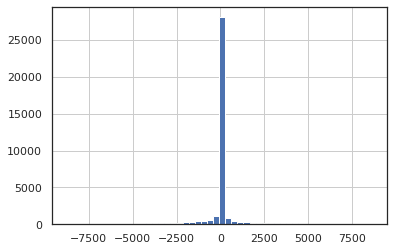

In [98]:
first_order_report['time_to_order'].hist(bins=50)

In [100]:
first_order_report.query('time_to_order > 0').median()

Uid              9.244610e+18
time_to_order    2.000000e-01
dtype: float64

Построив распределение, видим, что много выбросов. Очищаю методом query, в котором оставляю только значения больше 0, и уже по очищенным значениям считаю медиану. С момента первого посещения сайта пользователем до момента покупки проходит приблизительно 20 минут.

<strong>Сколько раз покупают за период?</strong>

Посчитаем общее кол-во заказов в месяц

In [101]:
orders['date_month'] = orders['Buy Ts'].astype('datetime64[M]')

In [102]:
monthly_total_orders = orders.groupby('date_month').agg({'Uid': 'count'}).reset_index()

In [103]:
monthly_total_orders = monthly_total_orders.rename(columns={'Uid': 'monthly_total_orders'})

Посчитаем кол-во уникальных пользователей в месяц

In [104]:
monthly_users_count = orders.groupby('date_month').agg({'Uid': 'nunique'}).reset_index()

In [105]:
monthly_users_count = monthly_users_count.rename(columns={'Uid': 'monthly_users_count'})

Объединим полученные таблички

In [106]:
monthly_orders_report = monthly_total_orders.merge(monthly_users_count, on='date_month')

In [107]:
monthly_orders_report['monthly_mean_orders'] = monthly_orders_report['monthly_total_orders'] / monthly_orders_report['monthly_users_count']

In [108]:
monthly_orders_report.head()

,date_month,monthly_total_orders,monthly_users_count,monthly_mean_orders
0,2017-06-01,2354,2023,1.163618
1,2017-07-01,2363,1984,1.191028
2,2017-08-01,1807,1472,1.227582
3,2017-09-01,3387,2750,1.231636
4,2017-10-01,5679,4675,1.214759


In [109]:
monthly_orders_report['monthly_mean_orders'].describe()

count    13.000000
mean      1.205823
std       0.068470
min       1.000000
25%       1.192784
50%       1.226298
75%       1.240254
max       1.273858
Name: monthly_mean_orders, dtype: float64

<code style="background:lavender;color:black">В среднем один уникальный пользователь делает 1.2 заказа в месяц

<strong>Какой средний чек?</strong>

In [113]:
orders['Revenue'].mean()

4.999646930477041

<code style="background:lavender;color:black"> Средний чек примерно 4.9

<strong>Сколько денег приносят? (LTV)</strong>

В табличке costs создадим столбец с месяцами

In [114]:
costs['date_month'] = costs['dt'].astype('datetime64[M]')

Получим месяц первой покупки каждого покупателя

In [115]:
first_order_month = orders.groupby('Uid').agg({'date_month': 'min'}).reset_index()

In [116]:
first_order_month = first_order_month.rename(columns={'date_month': 'first_order_month'})

In [117]:
first_order_month.head()

,Uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


Посчитаем кол-во новых покупателей за каждый месяц

In [118]:
cohort_sizes = first_order_month.groupby('first_order_month').agg({'Uid': 'nunique'}).reset_index()

In [119]:
cohort_sizes.columns = ['first_order_month', 'n_buyers']

In [120]:
cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


Добавим месяц первой покупки каждого покупателя в таблицу с заказами

In [121]:
orders_new = pd.merge(orders, first_order_month, on='Uid')

In [122]:
orders_new.sample(5)

,Buy Ts,Revenue,Uid,date_month,first_order_month
20780,2017-11-10 16:25:00,2.57,17027827441694981887,2017-11-01,2017-11-01
4854,2017-07-04 16:39:00,1.22,10843538492008849253,2017-07-01,2017-07-01
25971,2017-12-04 21:40:00,0.85,13593483968750933441,2017-12-01,2017-12-01
14912,2017-10-07 09:59:00,6.84,3904100052591291555,2017-10-01,2017-10-01
24598,2018-01-30 19:26:00,6.11,13150345141733477378,2018-01-01,2017-11-01


Построим когорты. Сгруппируем по месяцам первой покупки и по месяцу каждого заказа, просуммируем выручку.

In [123]:
cohort_orders = orders_new.groupby(['first_order_month', 'date_month']).agg({'Revenue': 'sum'}).reset_index()

In [124]:
cohort_orders.sample(5)

,first_order_month,date_month,Revenue
2,2017-06-01,2017-08-01,885.34
78,2018-06-01,2018-06-01,3.42
19,2017-07-01,2018-02-01,272.72
5,2017-06-01,2017-11-01,1487.92
28,2017-08-01,2018-01-01,388.45


Создадим табличку  report_orders, в которой к таблице с когортами добавим кол-во новых покупателей в каждый месяц.

In [125]:
report_orders = pd.merge(cohort_sizes, cohort_orders, on='first_order_month')

In [126]:
report_orders.head()

,first_order_month,n_buyers,date_month,Revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


Вычислим возраст каждой когорты

In [127]:
report_orders['age'] = (report_orders['date_month'] - report_orders['first_order_month']) / np.timedelta64(1, 'M')

In [128]:
report_orders['age'] = report_orders['age'].round().astype('int')

In [129]:
report_orders.head()

,first_order_month,n_buyers,date_month,Revenue,age
0,2017-06-01,2023,2017-06-01,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,4


Рассчитаем ltv

In [130]:
report_orders['ltv'] = report_orders['Revenue'] / report_orders['n_buyers']

In [131]:
report_orders.head()

,first_order_month,n_buyers,date_month,Revenue,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531


Построим сводную таблицу с ltv в каждом возрасте когорты

In [132]:
report_orders['first_order_month'] = report_orders['first_order_month'].dt.date

In [133]:
report_orders_pivot = report_orders.pivot_table(
index='first_order_month',
columns='age',
values='ltv',
aggfunc='mean').round(2)

In [134]:
report_orders_pivot = report_orders_pivot.cumsum(axis=1)

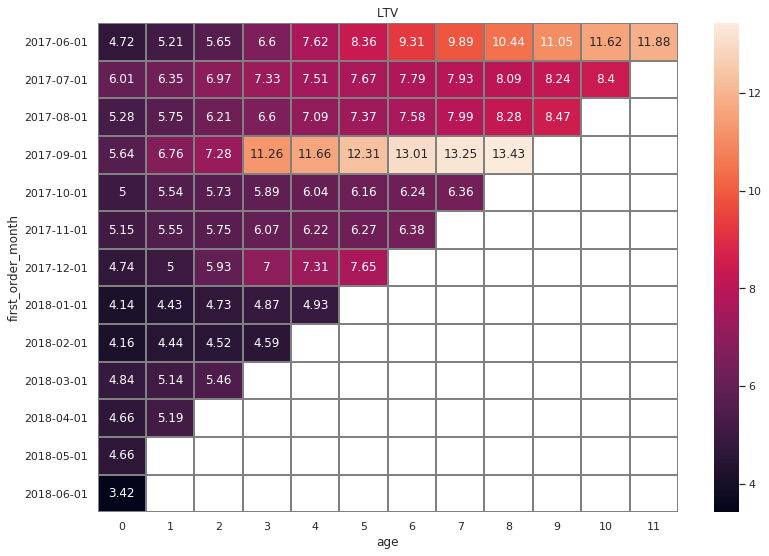

In [135]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('LTV')
sns.heatmap(report_orders_pivot, annot=True, fmt='g', linewidths=1, linecolor='gray')

Теперь посчитаем ltv в разрезе девайсов, для расчета создадим табличку users - профиль пользователя, в котором есть дата, источник и устройство первого посещения, по которой будем также высчитывать некоторые показатели и далее.

In [136]:
costs['acquisition_date'] = costs['dt']

In [137]:
costs.head()

,source_id,dt,costs,date_month,acquisition_date
0,1,2017-06-01,75.20,2017-06-01,2017-06-01
1,1,2017-06-02,62.25,2017-06-01,2017-06-02
2,1,2017-06-03,36.53,2017-06-01,2017-06-03
3,1,2017-06-04,55.00,2017-06-01,2017-06-04
4,1,2017-06-05,57.08,2017-06-01,2017-06-05


Создаем табличку users, в которой по каждому пользователю будут дата привлечения, устройство и источник

In [138]:
users = (visits.sort_values(by = ['Uid', 'Start Ts']).groupby('Uid')
        .agg({'Start Ts': 'first', 'source_id': 'first', 'Device': 'first'})
        .rename(columns = {'Start Ts': 'acquisition_ts'}))

In [139]:
users.head()

,acquisition_ts,source_id,Device
Uid,,,
11863502262781,2018-03-01 17:27:00,3,touch
49537067089222,2018-02-06 15:55:00,2,touch
297729379853735,2017-06-07 18:47:00,3,desktop
313578113262317,2017-09-18 22:49:00,2,desktop
325320750514679,2017-09-30 14:29:00,5,desktop


Создадим два столбца: с датой привлечения в формате даты, с месяцем привлечения

In [140]:
users['acquisition_date'] = users['acquisition_ts'].dt.date
users['acquisition_month'] = users['acquisition_ts'].astype('datetime64[M]')

В табличку users присоединим табличку costs по дате привлечения и источнику

In [141]:
users = (users.reset_index().set_index(['source_id', 'acquisition_date'])
        .join(costs.set_index(['source_id', 'acquisition_date']), how='left'))

In [142]:
users.head()

Uid      acquisition_ts   Device  \
source_id acquisition_date                                                     
1         2017-06-01         469568501030474895 2017-06-01 05:30:00  desktop   
          2017-06-01         618675438905551322 2017-06-01 02:37:00    touch   
          2017-06-01        1074355127080856382 2017-06-01 09:21:00  desktop   
          2017-06-01        1292867924428534308 2017-06-01 12:53:00  desktop   
          2017-06-01        1548840741623289234 2017-06-01 01:18:00  desktop   

                           acquisition_month         dt  costs date_month  
source_id acquisition_date                                                 
1         2017-06-01              2017-06-01 2017-06-01   75.2 2017-06-01  
          2017-06-01              2017-06-01 2017-06-01   75.2 2017-06-01  
          2017-06-01              2017-06-01 2017-06-01   75.2 2017-06-01  
          2017-06-01              2017-06-01 2017-06-01   75.2 2017-06-01  
          2017-06-01              2017-06-01 2017-06-01   75.2 2017-06-01

Создадим табличку user_cost, в которой посчитаем кол-во пользователей на каждую дату привлечения и источник

In [143]:
user_cost = (users.groupby(['source_id', 'acquisition_date']).agg({'Device': 'count', 'costs': 'max'})
            .rename(columns = {'Device': 'users'}))

In [144]:
user_cost.head()

users  costs
source_id acquisition_date              
1         2017-06-01           47  75.20
          2017-06-02           27  62.25
          2017-06-03           22  36.53
          2017-06-04           23  55.00
          2017-06-05           39  57.08

Вычислим стоимость привлечения одного пользователя

In [145]:
user_cost['acquisition_cost'] = user_cost['costs'] / user_cost['users']

In [146]:
user_cost.head()

users  costs  acquisition_cost
source_id acquisition_date                                
1         2017-06-01           47  75.20          1.600000
          2017-06-02           27  62.25          2.305556
          2017-06-03           22  36.53          1.660455
          2017-06-04           23  55.00          2.391304
          2017-06-05           39  57.08          1.463590

В табличку users добавим столбец со стоимостью привлечения каждого пользователя

In [147]:
users = users.join(user_cost[['acquisition_cost']], how='left')

In [148]:
users.head()

Uid      acquisition_ts   Device  \
source_id acquisition_date                                                     
1         2017-06-01         469568501030474895 2017-06-01 05:30:00  desktop   
          2017-06-01         618675438905551322 2017-06-01 02:37:00    touch   
          2017-06-01        1074355127080856382 2017-06-01 09:21:00  desktop   
          2017-06-01        1292867924428534308 2017-06-01 12:53:00  desktop   
          2017-06-01        1548840741623289234 2017-06-01 01:18:00  desktop   

                           acquisition_month         dt  costs date_month  \
source_id acquisition_date                                                  
1         2017-06-01              2017-06-01 2017-06-01   75.2 2017-06-01   
          2017-06-01              2017-06-01 2017-06-01   75.2 2017-06-01   
          2017-06-01              2017-06-01 2017-06-01   75.2 2017-06-01   
          2017-06-01              2017-06-01 2017-06-01   75.2 2017-06-01   
          2017-06-01              2017-06-01 2017-06-01   75.2 2017-06-01   

                            acquisition_cost  
source_id acquisition_date                    
1         2017-06-01                     1.6  
          2017-06-01                     1.6  
          2017-06-01                     1.6  
          2017-06-01                     1.6  
          2017-06-01                     1.6

In [149]:
users = users.reset_index().set_index('Uid')[['acquisition_ts', 'acquisition_date', 'acquisition_month', 'source_id', 'Device', 'acquisition_cost']]

In [150]:
users.head()

,acquisition_ts,acquisition_date,acquisition_month,source_id,Device,acquisition_cost
Uid,,,,,,
469568501030474895,2017-06-01 05:30:00,2017-06-01,2017-06-01,1,desktop,1.6
618675438905551322,2017-06-01 02:37:00,2017-06-01,2017-06-01,1,touch,1.6
1074355127080856382,2017-06-01 09:21:00,2017-06-01,2017-06-01,1,desktop,1.6
1292867924428534308,2017-06-01 12:53:00,2017-06-01,2017-06-01,1,desktop,1.6
1548840741623289234,2017-06-01 01:18:00,2017-06-01,2017-06-01,1,desktop,1.6


Начнем расчет ltv по девайсам. Создадим табличку cohorts_ltv_device,сгруппированную по устройствам, в которой будут рассчитаны размер когорты(по девайсу) и суммарная стоимость привлечения

In [151]:
cohorts_ltv_device = (users.groupby('Device')
             .agg({'source_id': 'count', 'acquisition_cost': 'sum'})
               .rename(columns={'source_id': 'cohort_size'}))

In [152]:
cohorts_ltv_device

,cohort_size,acquisition_cost
Device,,
desktop,160795,235065.750929
touch,67374,94000.729071


Создадим табличку ltv, соединив таблички orders(из которой берем только выручку и месяц покупки) и users по пользователям

In [153]:
ltv = orders.set_index('Uid').join(users, how='left')[['acquisition_month', 'source_id', 'Device', 'date_month', 'Revenue']]

In [154]:
ltv.head()

,acquisition_month,source_id,Device,date_month,Revenue
Uid,,,,,
9223707061355654945,2017-10-01,9,touch,2017-10-01,4.64
9224005701666002943,2017-12-01,5,desktop,2017-12-01,3.36
9224005701666002943,2017-12-01,5,desktop,2018-03-01,3.67
9225406053864431006,2017-09-01,4,desktop,2017-12-01,0.43
9225479525411867039,2018-02-01,4,touch,2018-02-01,7.33


Вычислим age, отняв от месяца покупки месяц привлечения и поделив на timedelta

In [155]:
ltv['age_month'] = ((ltv['date_month'] - ltv['acquisition_month']) / np.timedelta64(1, 'M')).round().astype('int')

In [156]:
ltv.head()

,acquisition_month,source_id,Device,date_month,Revenue,age_month
Uid,,,,,,
9223707061355654945,2017-10-01,9,touch,2017-10-01,4.64,0
9224005701666002943,2017-12-01,5,desktop,2017-12-01,3.36,0
9224005701666002943,2017-12-01,5,desktop,2018-03-01,3.67,3
9225406053864431006,2017-09-01,4,desktop,2017-12-01,0.43,3
9225479525411867039,2018-02-01,4,touch,2018-02-01,7.33,0


Создадим табличку ltv_1, сгруппированную по устройствам и возрасту когорты, и посчитаем суммарную выручку в них

In [157]:
ltv_1 = ltv.groupby(['Device', 'age_month']).agg({'Revenue': 'sum'})

In [158]:
ltv_1.head()

Revenue
Device  age_month           
desktop 0          117165.49
        1           18442.39
        2           13011.79
        3           23398.22
        4            9767.11

Превратим в сводную таблицу

In [159]:
ltv_1 = (ltv_1.pivot_table
         (index='Device',
          columns='age_month',
          values='Revenue',
          aggfunc='sum'))

In [160]:
ltv_1

age_month,0,1,2,3,4,5,6,7,8,9,10,11
Device,,,,,,,,,,,,
desktop,117165.49,18442.39,13011.79,23398.22,9767.11,8385.28,5949.24,4255.13,3330.05,3540.78,2386.19,1698.10
touch,25142.97,4958.02,2144.67,1610.26,1256.24,1192.18,859.71,1179.49,961.59,907.61,284.98,229.71


Посчитаем аккумулируемую сумму

In [161]:
ltv_1 = ltv_1.cumsum(axis=1)

In [162]:
ltv_1

age_month,0,1,2,3,4,5,6,7,8,9,10,11
Device,,,,,,,,,,,,
desktop,117165.49,135607.88,148619.67,172017.89,181785.00,190170.28,196119.52,200374.65,203704.70,207245.48,209631.67,211329.77
touch,25142.97,30100.99,32245.66,33855.92,35112.16,36304.34,37164.05,38343.54,39305.13,40212.74,40497.72,40727.43


Присоединим сюда столбец с размером когорты(по девайсам) из таблички cohorts_ltv_device

In [163]:
ltv_1 = cohorts_ltv_device[['cohort_size']].join(ltv_1)

In [164]:
ltv_1

,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11
Device,,,,,,,,,,,,,
desktop,160795,117165.49,135607.88,148619.67,172017.89,181785.00,190170.28,196119.52,200374.65,203704.70,207245.48,209631.67,211329.77
touch,67374,25142.97,30100.99,32245.66,33855.92,35112.16,36304.34,37164.05,38343.54,39305.13,40212.74,40497.72,40727.43


Поделим каждый столбец на столбец с размером когорты, тем самым рассчитаем ltv в разрезе девайсов

In [165]:
ltv_1 = ltv_1.div(ltv_1['cohort_size'], axis=0).drop(columns = ['cohort_size'])

In [166]:
ltv_1.round(2)

,0,1,2,3,4,5,6,7,8,9,10,11
Device,,,,,,,,,,,,
desktop,0.73,0.84,0.92,1.07,1.13,1.18,1.22,1.25,1.27,1.29,1.3,1.31
touch,0.37,0.45,0.48,0.50,0.52,0.54,0.55,0.57,0.58,0.60,0.6,0.60


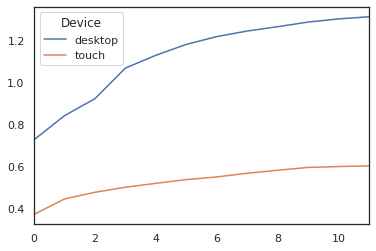

In [167]:
ltv_1.T.plot()

<code style="background:lavender;color:black">Видим,что покупатели, посещающие сайт с desktop версии, принесли больше денег, чем те, кто заходит с touch

Теперь посмотрим по источникам

In [168]:
cohorts_ltv_source = (users.groupby('source_id')
             .agg({'source_id': 'count', 'acquisition_cost': 'sum'})
               .rename(columns={'source_id': 'cohort_size'}))

In [169]:
cohorts_ltv_source

,cohort_size,acquisition_cost
source_id,,
1,9469,20833.27
2,17616,42806.04
3,66116,141321.63
4,72346,61073.60
5,49237,51756.40
6,2,0.00
7,32,0.00
9,6448,5454.42
10,6903,5821.12


In [170]:
ltv_2 = ltv.groupby(['source_id', 'age_month']).agg({'Revenue': 'sum'})

In [171]:
ltv_2 = (ltv_2.pivot_table
         (index='source_id',
          columns='age_month',
          values='Revenue',
          aggfunc='sum'))

In [172]:
ltv_2 = ltv_2.cumsum(axis=1)

In [173]:
ltv_2 = cohorts_ltv_source[['cohort_size']].join(ltv_2)

In [174]:
ltv_2 = ltv_2.div(ltv_2['cohort_size'], axis=0).drop(columns = ['cohort_size'])

In [175]:
ltv_2 = ltv_2.round(2).fillna('')
ltv_2

,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,1.53,1.81,2,2.29,2.47,2.59,2.68,2.92,3.05,3.14,3.23,3.28
2,1.02,1.36,1.7,2.07,2.25,2.39,2.46,2.51,2.55,2.6,2.64,2.66
3,0.57,0.66,0.7,0.73,0.76,0.78,0.8,0.81,0.81,0.82,0.82,0.82
4,0.52,0.58,0.61,0.64,0.66,0.69,0.72,0.73,0.74,0.76,0.77,0.78
5,0.58,0.65,0.7,0.92,0.95,1,1.02,1.04,1.05,1.06,1.07,1.07
6,,,,,,,,,,,,
7,0.04,,,,,,,,,,,
9,0.37,0.47,0.55,0.63,0.7,0.74,0.78,0.81,0.86,0.88,0.89,0.89
10,0.51,0.56,0.58,0.59,0.61,0.62,0.64,0.64,0.64,0.64,0.64,0.64


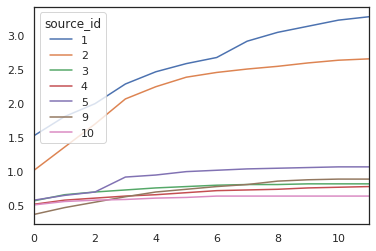

In [176]:
ltv_2.T.plot()

<code style="background:lavender;color:black"> Из графика видим, что пользователи из источников 1 и 2 приносят больше всего денег

#### Маркетинг

<strong>Сколько денег потратили? Всего / на каждый источник / по времени<strong>

In [177]:
costs['costs'].sum()

329131.62

<code style="background:lavender;color:black">Всего на маркетинг потратили 329131 рублей

In [178]:
costs.groupby('source_id')['costs'].sum()

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

<code style="background:lavender;color:black">Косты в разрезе источников. Больше всего потратили на источник номер 3, средне на 4,5 и 2. Меньше всего на источники 9 и 10. На источники 6 и 7 не выделили денег

In [179]:
monthly_costs = costs.groupby('date_month')['costs'].sum()

In [181]:
monthly_costs.head()

date_month
2017-06-01    18015.00
2017-07-01    18240.59
2017-08-01    14790.54
2017-09-01    24368.91
2017-10-01    36322.88
Name: costs, dtype: float64

<code style="background:lavender;color:black">Косты по месяцам. Больше всего потратили в декабре 2017 года.

In [182]:
costs_by_source = costs.groupby(['date_month', 'source_id']).agg({'costs': 'sum'}).reset_index()

In [183]:
costs_by_source.head()

,date_month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12


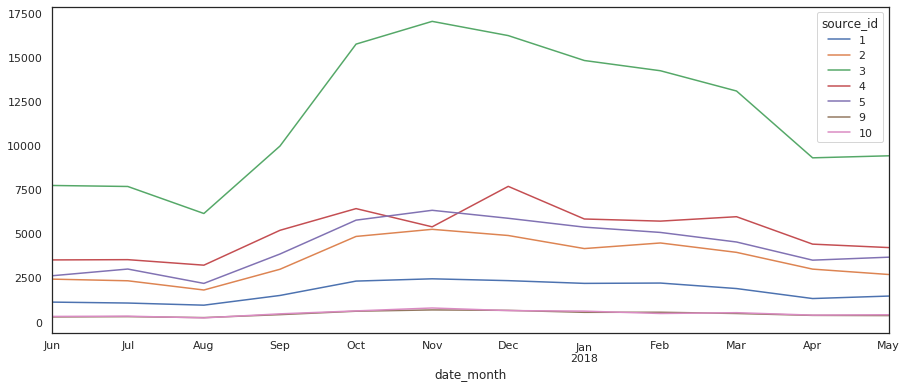

In [184]:
fig, ax = plt.subplots(figsize=(15, 6))
sources = costs_by_source['source_id'].unique()
for s in sources:
    (
        costs_by_source
        .query('source_id == @s')
        .pivot_table(index='date_month', columns='source_id', values='costs', aggfunc='first')
        .plot(ax=ax, kind='line', stacked=True)
    )

<code style="background:lavender;color:black"> Больше всего расходов было на источник 3. На втором месте источник №4.

<strong>Сколько стоило привлечение одного покупателя из каждого источника?</strong>

В полученную табличку report_orders добавим траты на маркетинг по месяцам

In [185]:
report_orders['first_order_month'] = report_orders['first_order_month'].astype('datetime64')

In [186]:
report_orders_new = report_orders.merge(monthly_costs, left_on = 'first_order_month', right_on='date_month')

И посчитаем cac, поделив столбец с ежемесячными расходами на кол-во новых покупателей в этом месяце

In [187]:
report_orders_new['cac'] = report_orders_new['costs'] / report_orders_new['n_buyers']

In [188]:
report_orders_new.sample(5)

,first_order_month,n_buyers,date_month,Revenue,age,ltv,costs,cac
41,2017-09-01,2581,2018-05-01,474.92,8,0.184006,24368.91,9.441654
64,2018-01-01,3373,2018-02-01,994.22,1,0.294758,33518.52,9.937302
5,2017-06-01,2023,2017-11-01,1487.92,5,0.735502,18015.00,8.905091
32,2017-08-01,1370,2018-05-01,257.53,9,0.187978,14790.54,10.796015
44,2017-10-01,4340,2017-12-01,830.65,2,0.191394,36322.88,8.369327


In [189]:
report_orders_new['cac'].mean()

9.319905176921116

<code style="background:lavender;color:black">Посчитали общую стоимость привлечения одного покупателя по когортам. В среднем это 9,3

Посмотрим стоимость привлечения одного покупателя с каждого источника, по уже созданной ранее табличке users

In [190]:
cac_source = users.groupby('source_id').agg({'acquisition_cost': 'mean'})

In [191]:
cac_source

,acquisition_cost
source_id,
1,2.200388
2,2.429952
3,2.137480
4,0.844188
5,1.051169
6,NaN
7,NaN
9,0.845909
10,0.843274


<code style="background:lavender;color:black">В среднем, привлечение одного покупателя дороже всего было из источников 1, 2 и 3, дешевле всего - источники 4,9 и 10

In [192]:
cac_graph = (users
             .groupby(['acquisition_month', 'source_id'])
             .agg({'acquisition_cost': 'mean'})
             .reset_index())

In [193]:
cac_graph_1 = cac_graph.dropna()

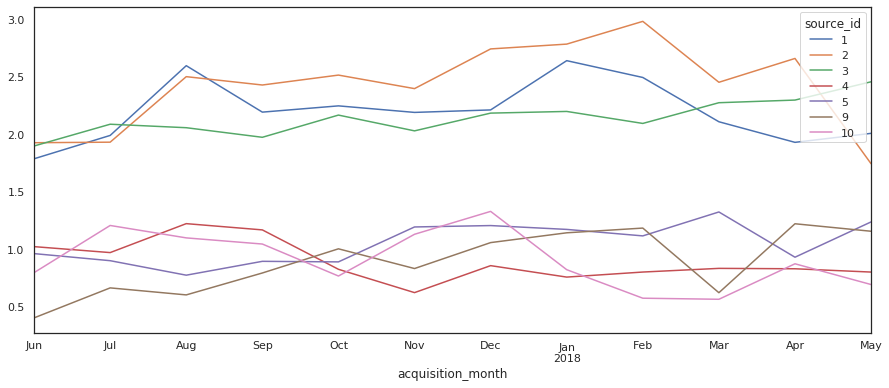

In [194]:
fig, ax = plt.subplots(figsize=(15, 6))
sources = cac_graph_1['source_id'].unique()
for s in sources:
    (
        cac_graph_1
        .query('source_id == @s')
        .pivot_table(index='acquisition_month', columns='source_id', values='acquisition_cost', aggfunc='first')
        .plot(ax=ax, kind='line', stacked=True)
    )

<strong>На сколько окупились расходы? (ROI)</strong>

Рассчитаем ROMI, поделив ltv на cac

In [195]:
report_orders_new['romi'] = report_orders_new['ltv']/report_orders_new['cac']

In [196]:
report_orders_new.sample(5)

,first_order_month,n_buyers,date_month,Revenue,age,ltv,costs,cac,romi
19,2017-07-01,1923,2018-02-01,272.72,7,0.141820,18240.59,9.485486,0.014951
32,2017-08-01,1370,2018-05-01,257.53,9,0.187978,14790.54,10.796015,0.017412
15,2017-07-01,1923,2017-10-01,690.31,3,0.358976,18240.59,9.485486,0.037845
22,2017-07-01,1923,2018-05-01,299.36,10,0.155673,18240.59,9.485486,0.016412
13,2017-07-01,1923,2017-08-01,644.61,1,0.335211,18240.59,9.485486,0.035339


In [197]:
report_orders_new['first_order_month'] = report_orders_new['first_order_month'].dt.date

In [198]:
report_orders_new_pivot = (report_orders_new
                           .pivot_table(index='first_order_month',
                                        columns='age', 
                                        values='romi', 
                                        aggfunc='mean'))

In [199]:
report_orders_new_pivot_1 = report_orders_new_pivot.cumsum(axis=1).round(2)

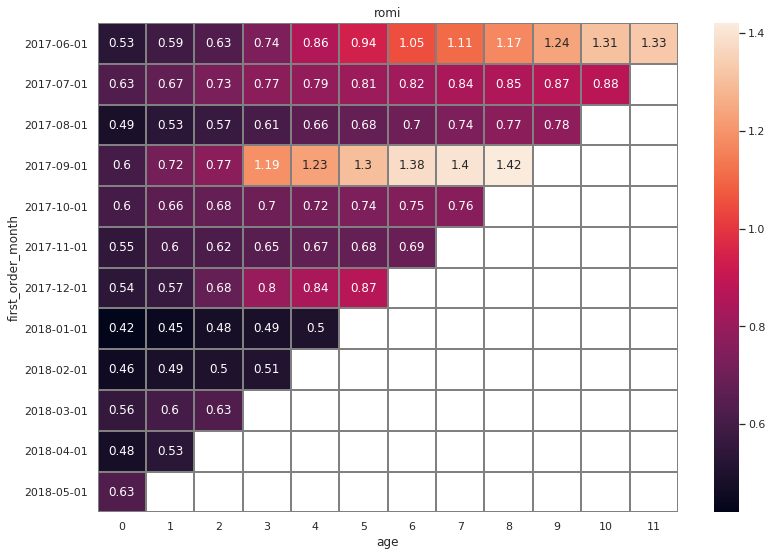

In [200]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('romi')
sns.heatmap(report_orders_new_pivot_1, annot=True, fmt='g', linewidths=1, linecolor='gray')

In [201]:
report_orders_new_pivot.cumsum(axis=1).mean(axis=0)

age
0     0.540816
1     0.581985
2     0.631069
3     0.719740
4     0.782946
5     0.859876
6     0.896819
7     0.969951
8     1.053871
9     0.964488
10    1.094658
11    1.333982
dtype: float64

<code style="background:lavender;color:black">В среднем окупаемость вложений в маркетинг наступает на 9-й месяц

Теперь посчитаем romi по устройствам

In [202]:
cohorts_ltv_device['cac'] = cohorts_ltv_device['acquisition_cost'] / cohorts_ltv_device['cohort_size']

In [203]:
cohorts_ltv_device

,cohort_size,acquisition_cost,cac
Device,,,
desktop,160795,235065.750929,1.461897
touch,67374,94000.729071,1.395208


In [204]:
romi_device = cohorts_ltv_device[['cac']].join(ltv_1)

In [205]:
romi_device

,cac,0,1,2,3,4,5,6,7,8,9,10,11
Device,,,,,,,,,,,,,
desktop,1.461897,0.728664,0.843359,0.924280,1.069796,1.130539,1.182688,1.219687,1.246150,1.266860,1.288880,1.303720,1.314281
touch,1.395208,0.373185,0.446775,0.478607,0.502507,0.521153,0.538848,0.551608,0.569115,0.583387,0.596858,0.601088,0.604498


In [206]:
romi_device = romi_device.div(romi_device['cac'], axis=0).drop(columns = ['cac'])

In [207]:
romi_device.round(2)

,0,1,2,3,4,5,6,7,8,9,10,11
Device,,,,,,,,,,,,
desktop,0.50,0.58,0.63,0.73,0.77,0.81,0.83,0.85,0.87,0.88,0.89,0.90
touch,0.27,0.32,0.34,0.36,0.37,0.39,0.40,0.41,0.42,0.43,0.43,0.43


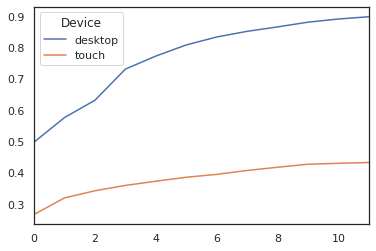

In [208]:
romi_device.T.plot()

<code style="background:lavender;color:black">Возврат инвестиций у десктоп выше

Теперь посчитаем romi по источникам

In [209]:
romi_sources = cac_source.join(ltv_2)

In [210]:
romi_sources.head()

,acquisition_cost,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,,
1,2.200388,1.53,1.81,2,2.29,2.47,2.59,2.68,2.92,3.05,3.14,3.23,3.28
2,2.429952,1.02,1.36,1.7,2.07,2.25,2.39,2.46,2.51,2.55,2.6,2.64,2.66
3,2.137480,0.57,0.66,0.7,0.73,0.76,0.78,0.8,0.81,0.81,0.82,0.82,0.82
4,0.844188,0.52,0.58,0.61,0.64,0.66,0.69,0.72,0.73,0.74,0.76,0.77,0.78
5,1.051169,0.58,0.65,0.7,0.92,0.95,1,1.02,1.04,1.05,1.06,1.07,1.07


In [211]:
romi_sources = romi_sources.div(romi_sources['acquisition_cost'], axis=0).drop(columns=['acquisition_cost'])

In [212]:
romi_sources = romi_sources.fillna('')

In [213]:
romi_sources

,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,0.695332,0.822582,0.908931,1.04073,1.12253,1.17707,1.21797,1.32704,1.38612,1.42702,1.46792,1.49065
2,0.419761,0.559682,0.699602,0.851869,0.925944,0.983558,1.01237,1.03294,1.0494,1.06998,1.08644,1.09467
3,0.266669,0.308775,0.327488,0.341524,0.355559,0.364916,0.374273,0.378951,0.378951,0.383629,0.383629,0.383629
4,0.615977,0.687051,0.722588,0.758125,0.781817,0.817354,0.852891,0.864737,0.876582,0.900274,0.912119,0.923965
5,0.551767,0.618359,0.665925,0.875216,0.903756,0.951322,0.970348,0.989375,0.998888,1.0084,1.01791,1.01791
6,,,,,,,,,,,,
7,,,,,,,,,,,,
9,0.437399,0.555615,0.650188,0.744761,0.827512,0.874799,0.922085,0.95755,1.01666,1.0403,1.05212,1.05212
10,0.604786,0.664078,0.687795,0.699654,0.723371,0.73523,0.758947,0.758947,0.758947,0.758947,0.758947,0.758947


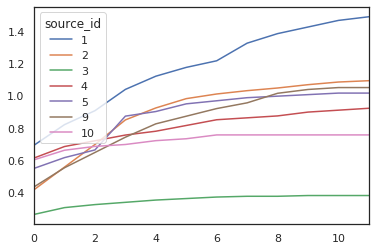

In [214]:
romi_sources.T.plot()

<code style="background:lavender;color:black"> По источнику 1 возврат инвестиций выше всего, далее у 2 и 5, средне у 9, 4 и 10. Хуже всего у 3

### Шаг 3. Общий вывод

<p>На основе полученных данных можно сделать следующие выводы:</p>
Десктоп версия лучше практически по всем показателям: пользователи, посещающие сайт с десктоп приносят больше денег за все время жизни, возврат инвестиций у десктоп значительно выше, чем у touch. С десктоп больше заходит уникальных пользователей, и по кол-ву сессий он также опережает touch, также выше коэффициент удержания пользователей. Так что однозначно можно сказать, что десктоп версия привлекательнее.

<p>По источникам:</p>
Больше всего денег принесли пользователи из источников 1 и 2, причем с значительной разницей, у них достаточно высокий cac, но это хорошо окупается, особенно у источника 1, по коэффициенту удержания у 1 и 2 показатели чуть выше, чем у половины. У источников 4, 3 и 5 больше всего кол-во уникальных посетителей и кол-во сессий, однако совсем невысокие ltv, а большие косты на источник 3, сильно снизили его romi, что превратило этот источник в совсем непривлекательный. 5-ый окупился, но медленно.

<p>Рекомендации:</p>
Я бы рекомендовала продолжать вкладываться в источники 1 и 2, поскольку они хорошо окупаются и приносят деньги. По устройству - десктоп.